In [11]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

sns.set_style('whitegrid')

# Problem definition

Cluster counties based on demographic and economic data

https://www.kaggle.com/muonneutrino/us-census-demographic-data/data

# Load the data

In [12]:
#input
#df = pd.read_csv('data/acs2015_county_data.csv')
df = pd.read_csv('declarations-exterminations-punaises-de-lit-1.csv')
#df = df.set_index(['CensusId', 'State', 'County'])
df = df.set_index(['NO_DECLARATION','BORO_NAME','HOOD_NAME'])
print(df.columns)
#print(df['BORO_NAME'])

Index(['DATE_DECLARATION', 'DATE_PRIOR_INSP', 'EXT_FREQ', 'DATE_FIRST_EXT',
       'DATE_LAST_EXT', 'HOOD_NUM', 'MTM8_X', 'MTM8_Y', 'LONGITUDE',
       'LATITUDE', 'LONG_LAT', 'MTM_X_Y', 'DEC_MONTH', 'DEC_ISSUE',
       'DATE_DIFF'],
      dtype='object')


In [13]:
# Ref.:https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html
df['DATE_DECLARATION'] = pd.to_datetime(df['DATE_DECLARATION'])
df['DATE_PRIOR_INSP'] = pd.to_datetime(df['DATE_PRIOR_INSP'])
df['DATE_FIRST_EXT'] = pd.to_datetime(df['DATE_FIRST_EXT'])
df['DATE_LAST_EXT'] = pd.to_datetime(df['DATE_LAST_EXT'])

#print(df.dtypes)

#print('==================TOP_10_BORO==================')
#((df.groupby(['BORO_NAME'])
#       .agg({'EXT_FREQ': sum, 'NO_DECLARATION':'count'}))
#       .sort_values(by = ['EXT_FREQ','NO_DECLARATION'],ascending=False)
#       .rename(columns={'EXT_FREQ':'EXT_QT','NO_DECLARATION':'DECL_QT'})
#       .head(10))
#print('')
#print('==================TOP_10_INTERSECTIONS_BASED_ON_EXT_FREQ_AND_ON_DECLARATIONS==================')
#((df.groupby(['LONG_LAT','HOOD_NAME','BORO_NAME'])
#       .agg({'EXT_FREQ': sum, 'NO_DECLARATION':'count'}))
#       .sort_values(by = ['EXT_FREQ','NO_DECLARATION'],ascending=False)
#       .rename(columns={'EXT_FREQ':'EXT_QT','NO_DECLARATION':'DECL_QT'})
#       .head(10))


# Inspication for epicenter calculation:
# https://towardsdatascience.com/transforming-categorical-data-for-usability-in-machine-learning-predictions-90459c3fc967?gi=2253c23cb822

# Ref. : https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1    
    
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2    
    c = 2 * np.arcsin(np.sqrt(a))
    
    km = 6367 * c
    return km




# Create distance column in dataframe, which returns km values
df['EPI_DIST_1'] = haversine_np(
    df['LONGITUDE'],df['LATITUDE'], -73.585636, 45.527404)

df['EPI_DIST_2'] = haversine_np(
    df['LONGITUDE'],df['LATITUDE'], -73.563652, 45.528809)



#We have this for month and year:

df['DEC_D'] = (pd.DatetimeIndex(df['DATE_DECLARATION']).year).map(str) + (
    pd.DatetimeIndex(df['DATE_DECLARATION']).month).map(str)
    
df['PRIOR_D'] = (pd.DatetimeIndex(df['DATE_PRIOR_INSP']).year).map(str) + (
    pd.DatetimeIndex(df['DATE_PRIOR_INSP']).month).map(str)

df['FIRST_D'] = (pd.DatetimeIndex(df['DATE_FIRST_EXT']).year).map(str) + (
    pd.DatetimeIndex(df['DATE_FIRST_EXT']).month).map(str)

df['LAST_D'] = (pd.DatetimeIndex(df['DATE_LAST_EXT']).year).map(str) + (
    pd.DatetimeIndex(df['DATE_LAST_EXT']).month).map(str)

# Create difference between LAST and FIRST Extermination
df['D_DIFF_B'] = round( (df['DATE_LAST_EXT'] - df['DATE_FIRST_EXT'] ) 
                                / np.timedelta64(1,'D') )
    # ['D_DIFF_B'] = ['DATE_LAST_EXT'] - ['DATE_FIRST_EXT']

# Create difference between LAST and FIRST Extermination
df['D_DIFF_C'] = round( (df['DATE_FIRST_EXT'] - df['DATE_PRIOR_INSP'] ) 
                                / np.timedelta64(1,'D') )
    # ['D_DIFF_C'] = ['DATE_FIRST_EXT'] - ['DATE_PRIOR_INSP']

    
# rename column
df['D_DIFF_A'] = df['DATE_DIFF'].copy() # ['D_DIFF_A'] = ['DATE_DECLARATION'] - ['DATE_PRIOR_INSP']


#DELETION
del df['DATE_DECLARATION']
del df['DATE_PRIOR_INSP']
del df['EXT_FREQ']
del df['DATE_FIRST_EXT']
del df['DATE_LAST_EXT']
del df['MTM8_X']
del df['MTM8_Y']
del df['HOOD_NUM']
del df['LONGITUDE'] 
del df['LATITUDE']
del df['LONG_LAT'] 
del df['MTM_X_Y']
del df['DEC_MONTH']
del df['DEC_ISSUE'] 
del df['DEC_D'] 
del df['PRIOR_D'] 
del df['FIRST_D'] 
del df['LAST_D'] 



print(df.columns)

#df.head()



Index(['DATE_DIFF', 'EPI_DIST_1', 'EPI_DIST_2', 'D_DIFF_B', 'D_DIFF_C',
       'D_DIFF_A'],
      dtype='object')


# Feature Engineering 

In [14]:
# remove NaNs


df = df.dropna()

#print(df.columns)
#print(df_norm.columns)

## remove column
X_columns = list(df.columns)
#if 'IncomeErr' in X_columns:
#    X_columns.remove('IncomeErr')
#if 'IncomePerCapErr' in X_columns:
#    X_columns.remove('IncomePerCapErr')
#df = df[X_columns]

#print(df_norm)


# normalize the columns
df_norm = df.copy()
for col in X_columns:
    df_norm[col] = StandardScaler().fit_transform(df_norm[col].values.reshape(-1, 1))
    #print(col)

print(df.shape)
df_norm.head()

(149, 6)


c:\users\lcler\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\lcler\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\lcler\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\lcler\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,,,DATE_DIFF,EPI_DIST_1,EPI_DIST_2,D_DIFF_B,D_DIFF_C,D_DIFF_A
NO_DECLARATION,BORO_NAME,HOOD_NAME,,,,,,
4254,Mercier–Hochelaga-Maisonneuve,Beaurivage,0.350752,1.502911,0.954907,-0.481152,-0.343594,0.350752
830,Le Sud-Ouest,Saint-Henri,1.116898,0.563470,0.557580,-0.111335,0.141671,1.116898
1380,Ville-Marie,Sainte-Marie,-0.497481,-0.756064,-1.244123,-0.234608,-0.170285,-0.497481
455,Côte-des-Neiges–Notre-Dame-de-Grâce,Upper Lachine,-0.634292,0.834791,0.958061,-0.481152,-0.343594,-0.634292
1243,Rosemont–La Petite-Patrie,Petite-Côte,0.432839,-0.527856,-0.758676,-0.481152,0.314980,0.432839


# Model Training

In [15]:
k = 7
kmeans = KMeans(n_clusters=k).fit(df_norm.values)

print(set(kmeans.labels_))
print(collections.Counter(kmeans.labels_))

df_results = df.copy()
df_norm['cluster'] = kmeans.labels_
df_results['cluster'] = kmeans.labels_

{0, 1, 2, 3, 4, 5, 6}
Counter({1: 45, 0: 42, 3: 27, 6: 16, 5: 12, 2: 5, 4: 2})


[('Villeray–Saint-Michel–Parc-Extension', 15), ('Mercier–Hochelaga-Maisonneuve', 10), ('Côte-des-Neiges–Notre-Dame-de-Grâce', 5), ('Le Sud-Ouest', 5), ('Rosemont–La Petite-Patrie', 3)]
[('Rosemont–La Petite-Patrie', 15), ('Le Plateau-Mont-Royal', 15), ('Ville-Marie', 9), ('Mercier–Hochelaga-Maisonneuve', 5), ('Villeray–Saint-Michel–Parc-Extension', 1)]
[('Villeray–Saint-Michel–Parc-Extension', 2), ('Le Plateau-Mont-Royal', 2), ('Rosemont–La Petite-Patrie', 1)]
[('Mercier–Hochelaga-Maisonneuve', 6), ('Montréal-Nord', 5), ('Côte-des-Neiges–Notre-Dame-de-Grâce', 3), ('Ahuntsic-Cartierville', 3), ('Anjou', 2)]
[('Le Plateau-Mont-Royal', 2)]
[('Le Plateau-Mont-Royal', 5), ('Ville-Marie', 4), ('Villeray–Saint-Michel–Parc-Extension', 2), ('Rosemont–La Petite-Patrie', 1)]
[('Côte-des-Neiges–Notre-Dame-de-Grâce', 4), ('Le Sud-Ouest', 3), ('Rosemont–La Petite-Patrie', 3), ('Saint-Léonard', 2), ('Saint-Laurent', 1)]
DATE_DIFF


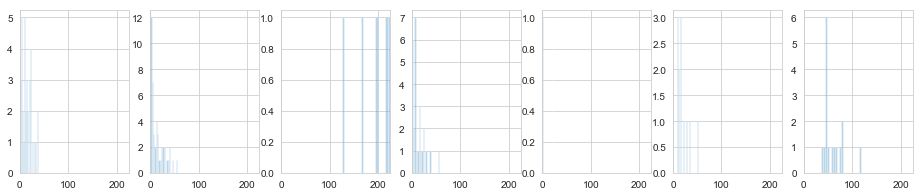

EPI_DIST_1


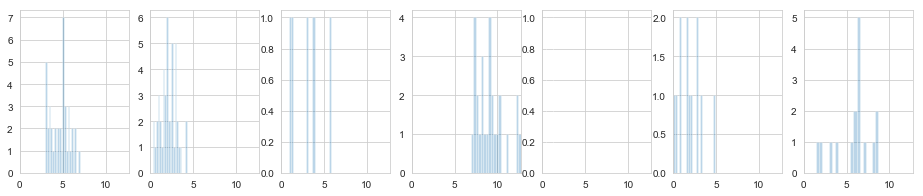

EPI_DIST_2


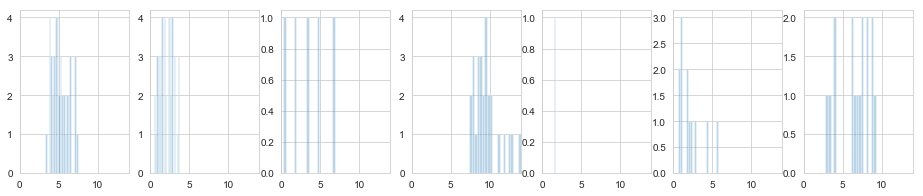

D_DIFF_B


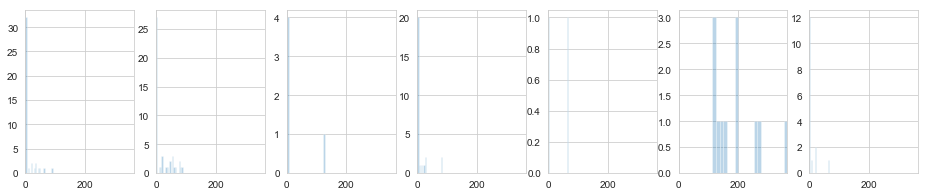

D_DIFF_C


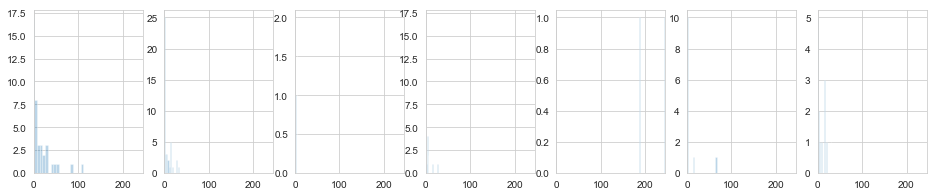

D_DIFF_A


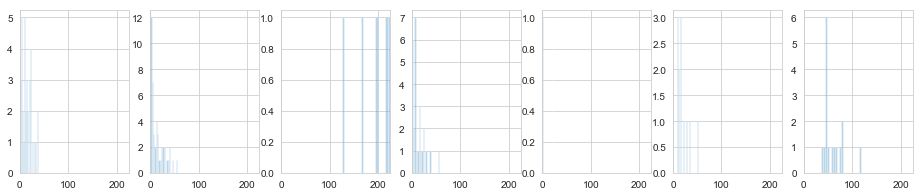

In [16]:
# Analyze the results
df_results = df_results.reset_index()
for cluster in sorted(set(kmeans.labels_)):
    print(collections.Counter(df_results[df_results['cluster']==cluster]['BORO_NAME']).most_common(5))

n_clusters = len(set(kmeans.labels_))
for col in X_columns:
    print(col)
    i = 1
    plt.figure(figsize=(16,3))
    for cluster in sorted(set(kmeans.labels_)):
        plt.subplot(1, n_clusters, i)
        plt.xlim([0,df_results[col].max()])
        plt.hist(df_results[df_results['cluster']==cluster][col], label=str(cluster), alpha=0.3, bins=20)
        i += 1
    plt.show()

In [17]:
# Analyze the centroids
df_results.groupby('cluster').mean().round(2).T

cluster,0,1,2,3,4,5,6
NO_DECLARATION,5228.38,5152.22,5116.60,4786.26,3640.50,6516.33,4920.44
DATE_DIFF,12.74,13.60,186.60,12.44,10.00,19.33,58.44
EPI_DIST_1,4.68,2.04,3.03,9.06,0.83,1.92,5.78
EPI_DIST_2,5.15,1.97,3.40,9.47,1.69,2.09,6.54
D_DIFF_B,9.50,19.31,27.00,9.81,33.50,185.00,7.25
D_DIFF_C,13.50,4.56,1.80,2.78,215.50,6.75,6.81
D_DIFF_A,12.74,13.60,186.60,12.44,10.00,19.33,58.44


DATE_DIFF


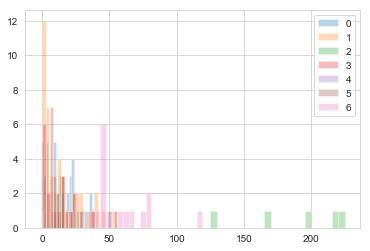

EPI_DIST_1


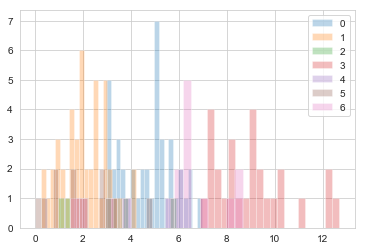

EPI_DIST_2


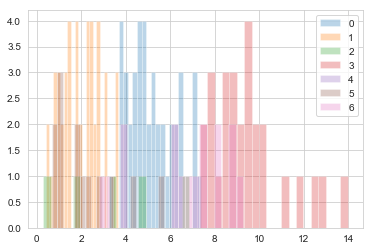

D_DIFF_B


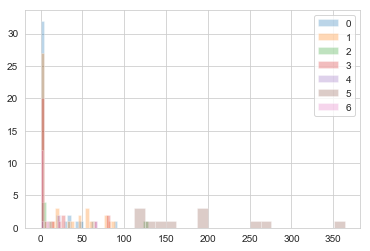

D_DIFF_C


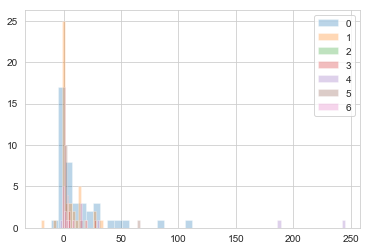

D_DIFF_A


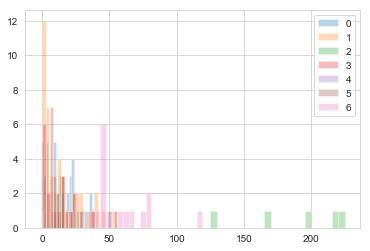

In [18]:
# Analyze the results
for col in X_columns:
    print(col)
    for cluster in set(kmeans.labels_):
        plt.hist(df_results[df_results['cluster']==cluster][col], label=str(cluster), alpha=0.3, bins=20)
    plt.legend()
    plt.show()

# Model Evaluation

In [19]:
# Inter-Cluster
centroids = []
for cluster in sorted(set(kmeans.labels_)):
    centroids.append(df_norm[df_norm['cluster']==cluster][X_columns].mean().values)
distances = []
for c1 in centroids:
    for c2 in centroids:
        distances.append(euclidean_distances(c1.reshape(-1, 1), c2.reshape(-1, 1))[0][0])
print('Inter Cluster distance', np.mean(distances))

# Intra-Cluster
distances = []
for cluster in sorted(set(kmeans.labels_)):
    df_filter = df_norm[df_norm['cluster']==cluster]
    centroid = df_filter[X_columns].mean().values
    for k, v in df_filter[X_columns].iterrows():
        distances.append(euclidean_distances(centroid.reshape(-1, 1), v.values.reshape(-1, 1))[0][0])
print('Intra Cluster distance', np.mean(distances))

# Inertia
distances = []
for cluster in sorted(set(kmeans.labels_)):
    df_filter = df_norm[df_norm['cluster']==cluster]
    centroid = df_filter[X_columns].mean().values
    for k, v in df_filter[X_columns].iterrows():
        distances.append(euclidean_distances(centroid.reshape(1, -1), v.values.reshape(1, -1), squared=True)[0][0])
print('Inertia', np.sum(distances))

Inter Cluster distance 1.4035910252661474
Intra Cluster distance 0.31092936303548735
Inertia 200.54788046172823


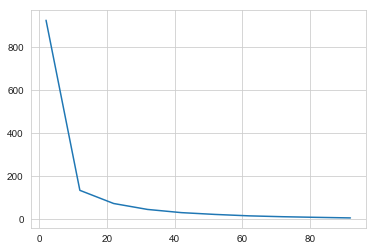

In [20]:
inertia = []
number_k = []
for k in range(2, 100, 10):
    kmeans = KMeans(n_clusters=k).fit(df_norm.values)
    inertia.append(kmeans.inertia_)
    number_k.append(k)
plt.plot(number_k, inertia)
plt.show()